### Phase 1: Data Collection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the UCI Wine dataset
wine = load_wine()
X = wine.data  # Features
y = wine.target  # Labels
feature_names = wine.feature_names
class_names = wine.target_names

# Create a DataFrame for easier manipulation
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Print basic information about the dataset
print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class names: {class_names}")
print(f"Feature names: {feature_names}")

Dataset Information:
Number of samples: 178
Number of features: 13
Number of classes: 3
Class names: ['class_0' 'class_1' 'class_2']
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


### Phase 2: Data Preparation & Cleaning

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# StandardScaler: This class is used to standardize the features by removing the mean
# and scaling to unit variance.

# Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Remove duplicate rows (if any)and convert them in numpy arr
df_cleaned = df_imputed.drop_duplicates()
X_cleaned = df_cleaned.drop('target', axis=1).values
y_cleaned = df_cleaned['target'].values

# Standardize the data (important for PCA and logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)

### Phase 3: Exploratory Data Analysis (EDA)


Summary Statistics:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.5723

<ipython-input-12-2fd87278b327>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_cleaned, palette='viridis')#bar chart


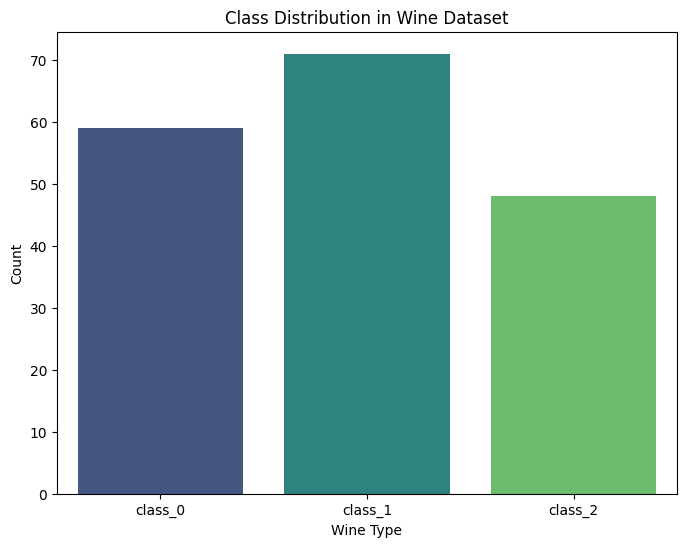

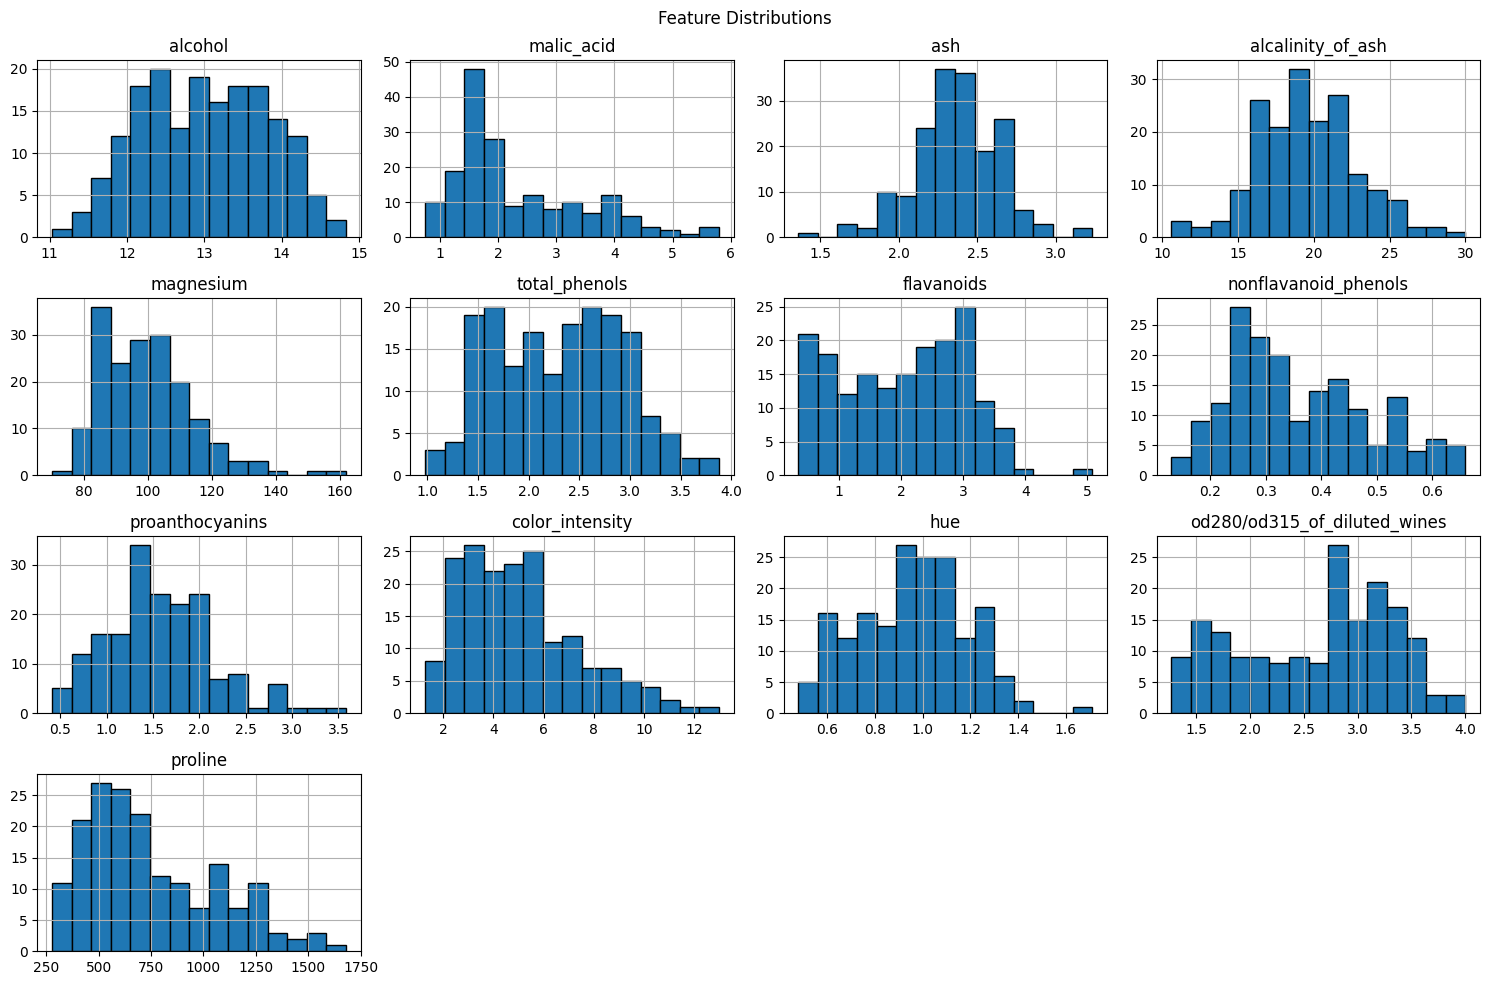

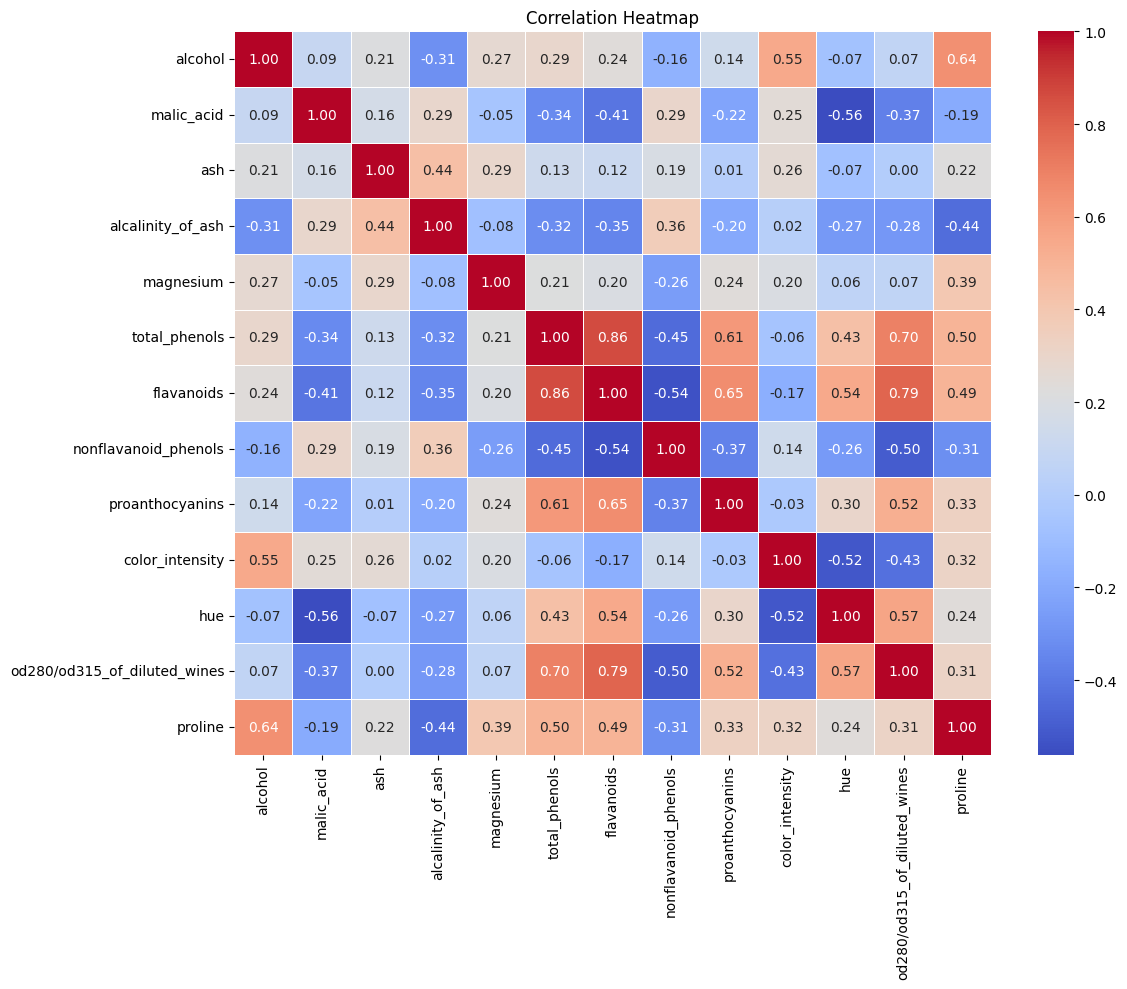

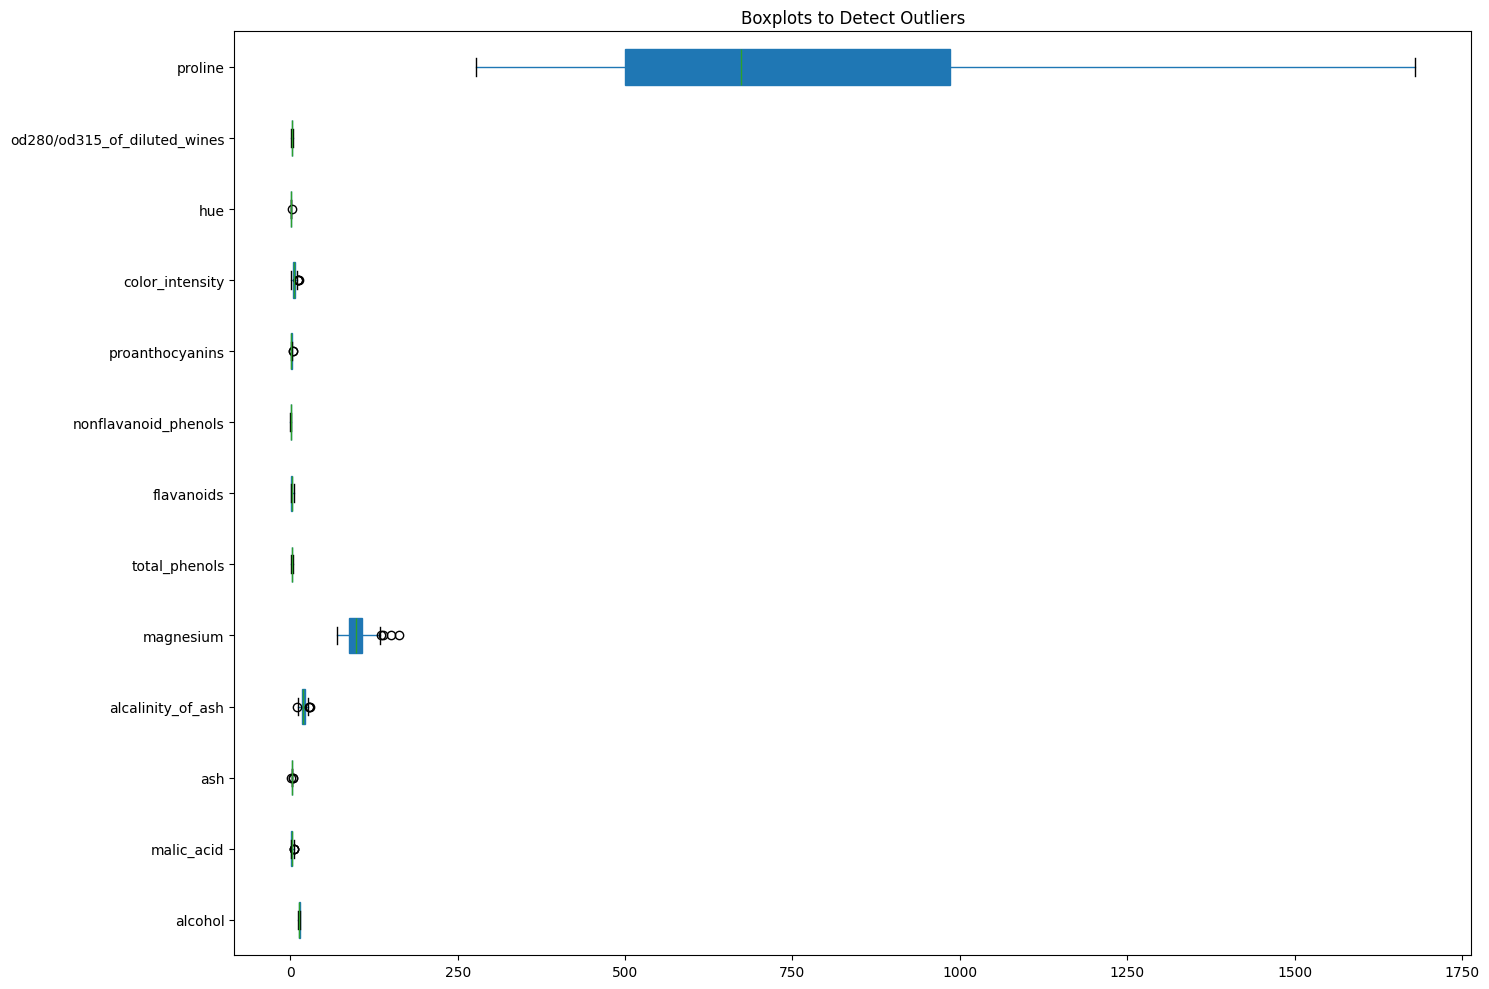

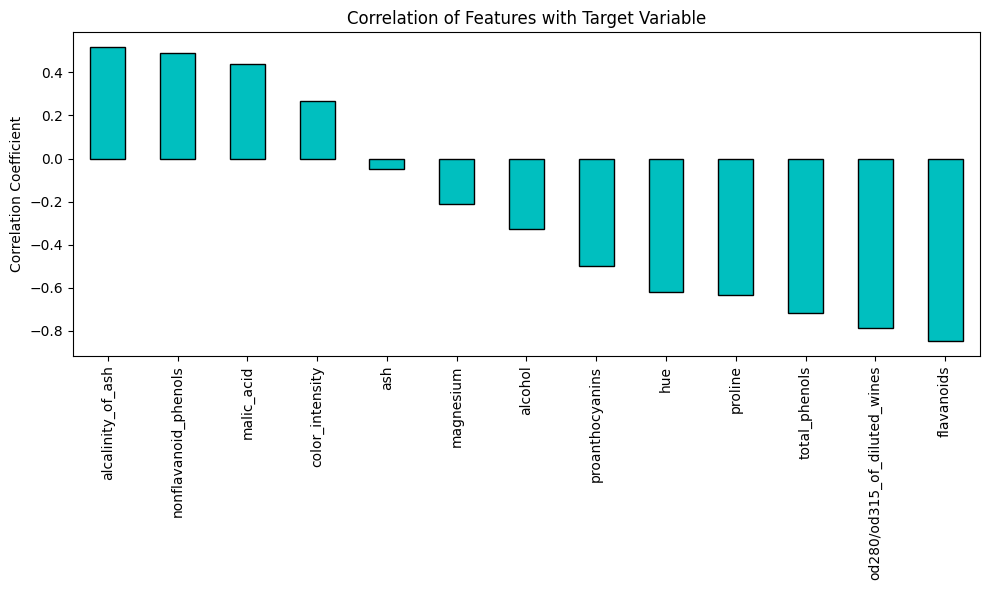

In [ ]:
print("\nSummary Statistics:")
print(df_cleaned.describe())

# Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_cleaned, palette='viridis')#bar chart
plt.title('Class Distribution in Wine Dataset')
plt.xlabel('Wine Type')
plt.ylabel('Count')
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

# Feature distributions
df_cleaned.drop('target', axis=1).hist(bins=15, figsize=(15, 10), edgecolor='k')
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_cleaned.drop('target', axis=1).corr()
#  colormap to 'coolwarm', which uses a blue-to-red color scale
#  to represent negative and positive correlations, respectively.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(15, 10))
df_cleaned.drop('target', axis=1).boxplot(grid=False, vert=False, patch_artist=True)
plt.title('Boxplots to Detect Outliers')
plt.tight_layout()
plt.show()

# Correlation with target variable
target_corr = df_cleaned.corr()['target'].drop('target')
plt.figure(figsize=(10, 6))
target_corr.sort_values(ascending=False).plot(kind='bar', color='c', edgecolor='k')
plt.title('Correlation of Features with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


### Phase 4: Feature Engineering & Selection


Features selected based on correlation (threshold=0.3):
['alcohol', 'malic_acid', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'hue', 'od280/od315_of_diluted_wines', 'proline']

Features selected based on variance: 13 of 13

Top 5 features based on ANOVA F-value:
['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

PCA explained variance ratio: [0.36198848 0.1920749 ]
Total variance explained: 0.5541


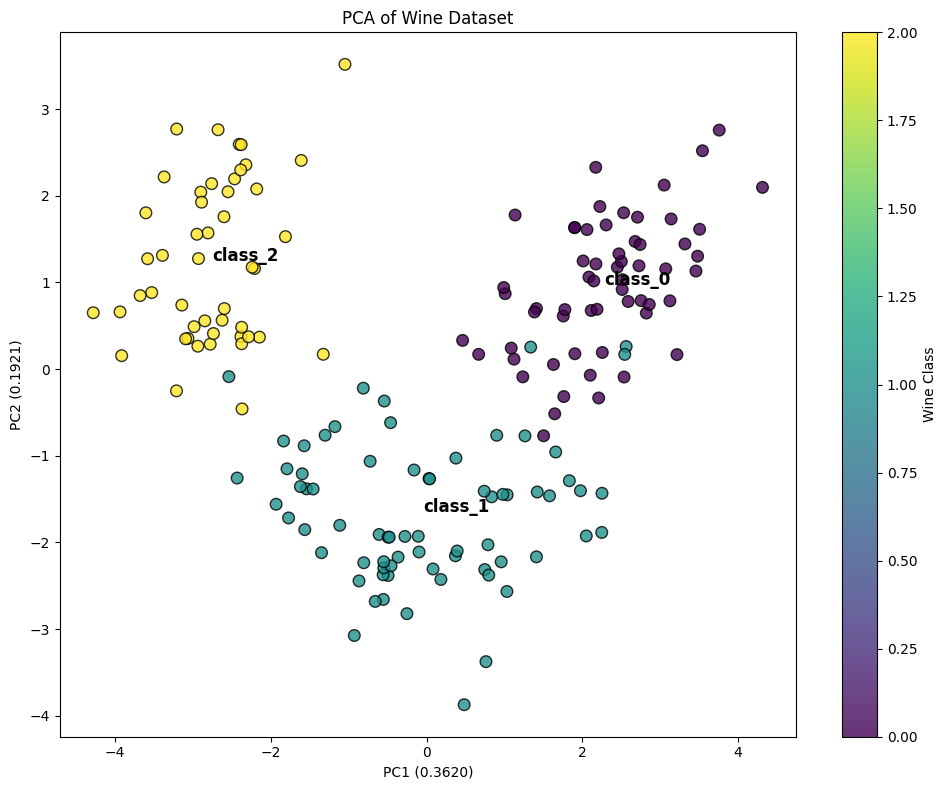

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA

# Method 1: Feature selection based on correlation with target
threshold = 0.3  # Adjust as needed
selected_features_corr = target_corr[abs(target_corr) > threshold].index
print(f"\nFeatures selected based on correlation (threshold={threshold}):")
print(selected_features_corr.tolist())

# Method 2: Feature selection based on variance
var_selector = VarianceThreshold(threshold=0.1)  # Adjust as needed
X_var_selected = var_selector.fit_transform(X_scaled)
print(f"\nFeatures selected based on variance: {X_var_selected.shape[1]} of {X_scaled.shape[1]}")

# Method 3: Feature selection based on ANOVA F-value
k_best = 5  # Select top 5 features, adjust as needed
selector = SelectKBest(f_classif, k=k_best)
X_kbest = selector.fit_transform(X_scaled, y_cleaned)
selected_mask = selector.get_support()
selected_features_kbest = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
print(f"\nTop {k_best} features based on ANOVA F-value:")
print(selected_features_kbest)

# Method 4: Dimensionality reduction using PCA
pca = PCA(n_components=2)  # Adjust as needed
X_pca = pca.fit_transform(X_scaled)
print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_cleaned, cmap='viridis', edgecolor='k', s=70, alpha=0.8)
plt.colorbar(scatter, label='Wine Class')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.4f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.4f})')
plt.title('PCA of Wine Dataset')

# Add class labels to the plot
for i, class_name in enumerate(class_names):
    class_center = X_pca[y_cleaned == i].mean(axis=0)
    plt.annotate(class_name, class_center, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Phase 5: Model Selection & Training

In [ ]:
# # We'll use the PCA-transformed data for our logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_cleaned, test_size=0.2, random_state=42)

# # Train a basic logistic regression model
basic_model = LogisticRegression(max_iter=1000) #Removed extra spaces before the line
#  The max_iter=1000 argument sets the maximum number of iterations for the solver to converge,
#  which can help in cases where the model takes longer to train.
basic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Phase 6: Model Evaluation & Optimization

GridSearchCV is a class in scikit-learn that is used to find the best hyperparameter settings for a given model by exhaustively searching through a specified parameter grid.


Basic model accuracy: 1.0000
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best model parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9648
Optimized model accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        14
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Confusion Matrix:


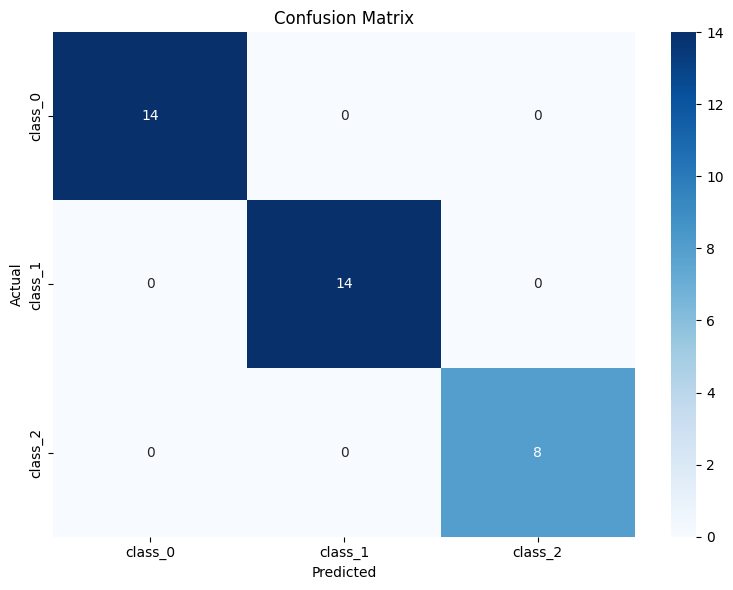

In [ ]:
# Evaluate the basic model
y_pred_basic = basic_model.predict(X_test)
# It compares the true labels of the test data (y_test) with the predicted labels (y_pred_basic).
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print(f"\nBasic model accuracy: {accuracy_basic:.4f}")

# Optimize the model using GridSearchCV-Regularization strength,The type of regularization ,algorithm for
param_grid = {

    'C': [0.01, 0.1, 1, 10, 100],

    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest model parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the optimized model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Optimized model accuracy: {accuracy_best:.4f}")

# Generate detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=class_names))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Predicted
#                ------------
# # Actual      | Class 0 | Class 1 | Class 2 |
# # ------------|---------|---------|---------|
# # Class 0     |  TN     |   FP    |   FP    |
# # Class 1     |  FP     |   TN    |   FP    |
# # Class 2     |  FP     |   FP    |   TN    |
# # ------------|---------|---------|---------|
#The lines above were added with # to make them comments and fix the IndentationError.

### Phase 7: Prediction & Interpretation

In [ ]:
# ---Prediction and Interpretation

# Create a new sample for prediction (example values)
new_sample = [[13.0, 2.0, 2.3, 20.0, 100.0, 2.65, 2.76, 0.26, 1.28, 4.38, 1.05, 3.40, 1050.0]]
# Adjust these values according to your features
#Instead of X.columns, use wine.feature_names as they are the true column names from the dataset.
new_sample_scaled = scaler.transform(pd.DataFrame(new_sample, columns=wine.feature_names))

#Instead of using selector.transform, we transform using pca directly after scaling.
# Apply PCA to the scaled new sample with all the features
new_sample_pca = pca.transform(new_sample_scaled)

# Make a prediction
predicted_class = best_model.predict(new_sample_pca)

# Get the class names for interpretation
class_names = wine.target_names

# Convert the predicted class to an integer
predicted_class = int(predicted_class[0])

# Print the prediction and interpretation
print(f"\nPrediction for new sample: {predicted_class}")
print(f"Predicted wine type: {class_names[predicted_class]}")# Create a new sample for prediction (example values)


Prediction for new sample: 0
Predicted wine type: class_0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
